This notebook is the newest workflow to test rectifications, remove bad GCPs and create error projection maps.


In [1]:
# imports
from __future__ import division
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.collections
import matplotlib.patches
import numpy.ma as ma
from scipy.stats import mode
from PIL import Image, ImageDraw
import pandas as pd
import os
import random
import sys
from scipy.interpolate import griddata

In [2]:
# if running in Colab, mount drive, otherwise comment out this block
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
site_names_list = ["RC0220Ra","RC0307Rf", "RC1227R","RC1459L"]
years_list = ["2017","2019"]

In [4]:

def get_sitename_and_year():
  '''
  a function that asks the user to define the sitename and year for rectification testing,
  sitename must be str and must be listed within the site_names_list which contains case-sensitive site names
  year should be a str and must be listed within the years list
  '''
  #site_names_list = ["RC0220Ra","RC0307Rf", "RC1227R","RC1459L"] #if not global variable, uncomment
  #years_list = ["2017","2019"] # if not global variable in script, uncomment

  # manually enter the sitename, the sitename chosen should be in the sitelist for which we have GCPs
  while True:
    try:
      sitename = str(input(f"Please specify sitename, choose from {site_names_list}:"))
      if sitename not in site_names_list:
          print("Sorry that is not in the current sites list")
          print(f"Try entering one of the following: {site_names_list}") 
      else:
          print(f"You selected {sitename}")
          break
    except ValueError:
        print("Sorry you entered the wrong datatype, please provide string name RC*****")
    else:
        print("Something is wrong with the input...is it a string?")
  # manually specify the year for the survey GCP panel photo
  while True:
    try:
      year_str = input(f"Please specify year of GCP panel photo, choose from {years_list}:")
      if year_str not in years_list:
          print("Sorry that is not in the current years list")
          print(f"Try entering one of the following: {years_list}")
      else:
          print(f"You selected {year_str}")
          break
    except ValueError:
        print("Sorry you entered the wrong datatype, please provide string for the year")
    else:
        print("Something is wrong with the input...")

  return sitename, year_str

sitename, year_str  = get_sitename_and_year()



Please specify sitename, choose from ['RC0220Ra', 'RC0307Rf', 'RC1227R', 'RC1459L']:RC0307Rf
You selected RC0307Rf
Please specify year of GCP panel photo, choose from ['2017', '2019']:2019
You selected 2019


Please enter the full path to the panel image/content/drive/My Drive/Colab_Notebooks/Rectification/RC0307Rf/Rec2020/RC0307Rf_20191007_1145_und.JPG
You selected: /content/drive/My Drive/Colab_Notebooks/Rectification/RC0307Rf/Rec2020/RC0307Rf_20191007_1145_und.JPG
File exists!
You have selected an image file with the correct site and year in the name
Panel image selected : RC0307Rf_20191007_1145_und.JPG


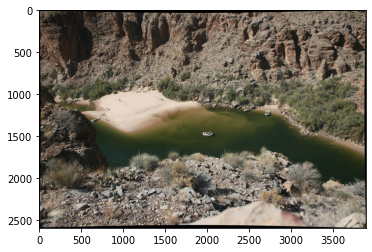

In [5]:
def get_image_load_cv2im(sitename, year_str):
  '''
  This function asks the user to provide a full path to a panel image,
  and returns img_bgr, img_rgb and plots the image
  but first it checks if the provided filepath exists, if it doesnt exist it will ask again
  then it checks if the filename contains the year_str and sitename defined previously,
  or in the function call, if the filename does not contain the year_str and sitename it asks
  if you want to continue anyway choose 'Y'
  
  '''
  try_again = True
  while try_again == True:
    panel_img_path = input("Please enter the full path to the panel image")
    print(f"You selected: {panel_img_path}")
    path, filename = os.path.split(panel_img_path)
    if os.path.exists(panel_img_path):
      print("File exists!")
      if sitename in panel_img_path and year_str in panel_img_path:
        print("You have selected an image file with the correct site and year in the name")
        print(f"Panel image selected : {filename}")
        try_again = False
      else:
        print("WARNING: the filename you provided does not contain specified sitename or year")
        keep_going = input("proceed Y/N? :").upper()
        if keep_going == "Y":
            print("we shall continue")
            print(f"Panel image selected : {filename}")
            try_again = False
        elif keep_going =="N":
          print("trying again")
        else:
          print("answer not recognized, trying again")
    else:
      print("Filepath or directory does not exist")
  # load image using cv2, by default it creates BGR image  
  img_bgr = cv2.imread(panel_img_path) # BGR image (cv2 default image type)
  # convert BGR image to RGB in case you need that
  img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB) # conver to RGB
  plt.imshow(img_rgb) # plot image
  return img_bgr, img_rgb # return both a BGR image and a RGB image

img_bgr,img_rgb = get_image_load_cv2im(sitename, year_str)    


In [23]:
# define impts and mappts
mappts = np.array([
[219542.644,611803.324],
#[219542.917,611790.645],
[219540.663,611778.078],
[219522.509,611775.796],
[219520.759,611764.155],
[219515.123,611754.640],
#[219529.343,611747.805],		
[219515.438,611733.189],
#[219541.495,611757.829],
[219542.715,611735.480],
#[219549.039,611767.098],
[219571.880,611771.835]
])

impts = np.array([
[1809.50,1095.75],
#[1577.75,1116.25],
[1354.50,1089.75],
[1388.75,968.00], 
[1211.50,983.75], 
[1093.75,968.50], 
#[975.00,1085.00],			
[782.00,1029.00], 
#[1001.75,1129.25],
[641.50,1238.50], 
#[1116.25,1174.75],
[1085.00,1426.00]
])




panel_img_str = 'RC0307Rf_20191007_1145_und.JPG'

Arrays are same shape: (8, 2)


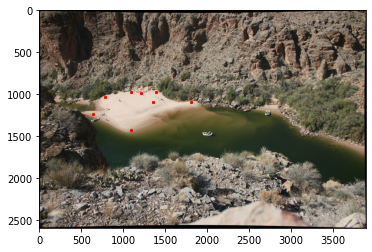

In [24]:
def check_impts_and_mappts(impts, mappts,img_rgb):
  ''' this function checks if the impts and mappts are arrays of the same length,
  then it plots the impts on the panel image. please provide:
  impts = np.array([[u1,v1],[u2,v2],...])
  mappts = np.array([[E1,N1],[E2,N2],...])
  '''
  if impts.shape == mappts.shape:
    print(f"Arrays are same shape: {impts.shape}")
    plt.imshow(img_rgb)
    plt.scatter(x = impts[:,0], y = impts[:,1], s = 5, c = 'r')
  else:
    print(f"Arrays have different shapes!")

check_impts_and_mappts(impts,mappts,img_rgb)  
  




In [8]:


class PanelDate:
  ''' a panel date object contains all the information needed to create a homography for a particular
  reference image. The reference image name is located within the __str__ method of the class

  Attributes:
  impts = U,V coordinates of GCPs in the impts_panel_img
  mappts = E,N coordinates of GCPs from impts_panel_img and survey, NAD83 AZ central state plane 0202 meters
  extent_buffer = user-defined buffer in meters which is added
    and subtracted from NE_max and NE_min which provides the extent of the rectified image
  E_min = the minimum Easting value within mappts, converted to int and padded with extent_buffer
  E_max = the maximum Easting value within mappts, converted to int and padded with extent_buffer
  N_min = the minimum Northing value within mappts, converted to int and padded with extent_buffer
  N_max = the maximum Northing value within mappts, converted to int and padded with extent_buffer
  EN_min = tuple containing (E_min, N_min)
  EN_max = tuple containing (E_max, N_max)
  minpts = list containing [E_min,N_min]
  N_ext = distance in meters along the north axis of the rectified output
  E_ext = distance in meters along the east axis of the rectified output
  dsize = size of the rectified image in meters, for 1x1meter pixels
  usepts = evenly spaced spaced values the length of the impts list 
  pts = mappts - minpts, cv2.findHomography has trouble with really large numbers like the 6 digit ENs
  ptsHiRes = (mappts - minpts)*10 this creates a larger image where each pixel is actually .1x.1 meters
  N_ext_HiRes = N_ext * 10
  E_ext_HiRes = E_ext * 10
  dsizeHiRes =  (E_ext_HiRes, N_ext_HiRes)
    therefore we subtract the minpts from the mappts
  impts_panel_img = the name of the panel image where the impts of GCPs were attained

  When creating a homography with 1x1 meter pixels use the following:
  H, _ = cv2.findHomography(PanelDate.impts[PanelDate.usepts], PanelDate.pts[PanelDate.usepoints])

  When creating a homography with .1x.1 meter pixels use the following:
  H, _ = cv2.findHomography(PanelDate.impts[PanelDate.usepts], PanelDate.ptsHiRes[PanelDate.usepoints])

  when applying the homography to an image use dsize for 1x1 meter homography
   and dsizeHiRes for .1x.1m homography
  '''
  def __init__(self,sitename, year, impts, mappts,panel_img_str,extent_buffer = 30):
    self.sitename = sitename
    #site_names_list = ["RC0220Ra","RC0307Rf", "RC1227R","RC1459L"]
    if sitename not in site_names_list:
      print('Error! provided sitename not in list of sites')
    self.year = year
    #years_list = ["2017","2019"]
    if year not in years_list:
      print('Error! provided year not in years list')
    self.impts = impts
    self.mappts = mappts
    self.extent_buffer = extent_buffer
    self.E_min = int(np.min(self.mappts[:,0]) - self.extent_buffer)
    self.E_minHiRes = self.E_min*10
    self.E_max = int(np.max(self.mappts[:,0]) + self.extent_buffer)
    self.E_maxHiRes = self.E_max*10
    self.N_min = int(np.min(self.mappts[:,1]) - self.extent_buffer)
    self.N_minHiRes = self.N_min*10
    self.N_max = int(np.max(self.mappts[:,1]) + self.extent_buffer)
    self.N_maxHiRes = self.N_max*10
    self.EN_min = (self.E_min, self.N_min)
    self.EN_max = (self.E_max, self.N_max)
    self.minpts = [self.E_min, self.N_min]
    self.minptsHiRes = [self.E_minHiRes, self.N_minHiRes]
    self.N_ext = (self.N_max - self.N_min)
    self.E_ext = (self.E_max - self.E_min)
    self.dsize = (self.E_ext,self.N_ext)
    self.usepts = np.arange(len(self.impts)) # evenly spaced values the length of impts
    self.pts = self.mappts - self.minpts
    self.ptsHiRes = self.pts*10
    self.N_ext_HiRes = self.N_ext*10
    self.E_ext_HiRes = self.E_ext*10
    self.dsizeHiRes = (self.E_ext_HiRes, self.N_ext_HiRes)
    self.impts_panel_img = panel_img_str
    

# METHODS ........................
  def compare_impts_and_mappts(self):
    '''
    This method can be run to check if the impts and mappts arrays provided are the same shape.
    impts = np.array([[u1,v1],[u2,v2],...])
    mappts = np.array([[E1,N1],[E2,N2],...])  
    '''
    if self.impts.shape == self.mappts.shape:
      print(f"Arrays are same shape: {self.impts.shape}")
    else:
      print(f"Arrays have different shapes!")
    print('impts:',self.impts)
    print('mappts:', self.mappts)



  
  def __str__(self):
    return self.sitename + ':' + self.year + '\n' + str(len(self.mappts)) + " GCPs\nimpts from:" + self.impts_panel_img 

In [25]:
RC0307Rf_2019 = PanelDate(sitename, year_str,impts,mappts,panel_img_str)

In [26]:
print(RC0307Rf_2019)

RC0307Rf:2019
8 GCPs
impts from:RC0307Rf_20191007_1145_und.JPG


In [11]:
def transform_points(impts, H, N_min, E_min):
  '''
  a function which transforms points using a homography

  inputs:
   H = numpy array:3x3 homography
   impts = np.array of U,V coordinates for GCPs
   N_min = the minimum northing in the rectified image - extent_buffer
   E_min = the minimum easitng in the rectified image - extent_buffer

   returns:
   transE = np.array of impts[:,0] transformed to eastings
   transN = np.array of impts[:,1] transformed to northings
  '''
  fct = 1
  x = np.array(impts[:,0])
  y = np.array(impts[:,1])
  points = np.vstack((fct*x,fct*y, np.ones(len(x))))
  txyz = H.dot(points)
  tx = txyz[0,:]
  ty = txyz[1,:]
  tz = txyz[2,:]
  tx = tx/tz
  ty = ty/tz
  txc = tx + E_min
  tyc = ty + N_min
  transE = np.array(txc)
  transN = np.array(tyc)
  return transE, transN


In [12]:
def rectify_hi_res(PanelDate,img_rgb, plot = True):
  H, trans = cv2.findHomography(PanelDate.impts[PanelDate.usepts],PanelDate.ptsHiRes[PanelDate.usepts])
  print(f'Homography with .1x.1 meter pixels\n {H}')
  dst = cv2.warpPerspective(img_rgb, H, PanelDate.dsizeHiRes)
  rows, cols, chanels = dst.shape
  E_axis = np.linspace(PanelDate.minptsHiRes[0], PanelDate.minptsHiRes[0] + cols, rows)
  N_axis = np.linspace(PanelDate.minptsHiRes[1], PanelDate.minptsHiRes[1] + rows, rows)
  if plot == True:
    fig = plt.figure()
    fig.subplots_adjust(wspace = 0.5)
    #plot original image
    ax = plt.subplot(1,2,1)
    plt.title("Original Image")
    plt.imshow(img_rgb)
    plt.scatter(x = PanelDate.impts[:,0],y = PanelDate.impts[:,1], c = 'r', s = 15 )
    ax.get_xaxis().get_major_formatter().set_useOffset(False)
    ax.get_yaxis().get_major_formatter().set_useOffset(False)
    labels = ax.get_xticklabels()
    plt.setp(labels, rotation=30, fontsize=8)
    labels = ax.get_yticklabels()
    plt.setp(labels, rotation=30, fontsize=8)
    # plot rectified Image
    ax = plt.subplot(1,2,2)
    plt.title("Rectified Image")
    ext =  [E_axis.min(), E_axis.max(), N_axis.min(), N_axis.max()]
    plt.imshow(dst, extent = ext, origin= 'lower')
    mapx = PanelDate.ptsHiRes[:,0] + PanelDate.minptsHiRes[0]
    mapy = PanelDate.ptsHiRes[:,1] + PanelDate.minptsHiRes[1]
    plt.scatter(x = mapx , y = mapy, c = 'r', s = 15 )
    transE, transN = transform_points(PanelDate.impts, H, PanelDate.N_minHiRes, PanelDate.E_minHiRes)
    plt.scatter(x  = transE, y = transN, c = 'b', s = 15 )

  else:
    print("Plot = False")
  
  return dst, H




def rectify_low_res(PanelDate,img_rgb,plot = True):
  H, trans = cv2.findHomography(PanelDate.impts[PanelDate.usepts],PanelDate.pts[PanelDate.usepts])
  print(f'Homography with 1x1 meter pixels\n {H}')
  dst = cv2.warpPerspective(img_rgb, H, PanelDate.dsize)
  rows, cols, chanels = dst.shape
  E_axis = np.linspace(PanelDate.minpts[0], PanelDate.minpts[0] + cols, rows)
  N_axis = np.linspace(PanelDate.minpts[1], PanelDate.minpts[1] + rows, rows)
  if plot == True:
    fig = plt.figure()
    fig.subplots_adjust(wspace = 0.5)
    #plot original image
    ax = plt.subplot(1,2,1)
    plt.title("Original Image")
    plt.imshow(img_rgb)
    plt.scatter(x = PanelDate.impts[:,0],y = PanelDate.impts[:,1], c = 'r', s = 15 )
    ax.get_xaxis().get_major_formatter().set_useOffset(False)
    ax.get_yaxis().get_major_formatter().set_useOffset(False)
    labels = ax.get_xticklabels()
    plt.setp(labels, rotation=30, fontsize=8)
    labels = ax.get_yticklabels()
    plt.setp(labels, rotation=30, fontsize=8)
    # plot rectified Image
    ax = plt.subplot(1,2,2)
    plt.title("Rectified Image")
    ext =  [E_axis.min(), E_axis.max(), N_axis.min(), N_axis.max()]
    plt.imshow(dst, extent = ext, origin= 'lower')
    mapx = PanelDate.pts[:,0] + PanelDate.minpts[0]
    mapy = PanelDate.pts[:,1] + PanelDate.minpts[1]
    plt.scatter(x = mapx , y = mapy, c = 'r', s = 15 )
    transE, transN = transform_points(PanelDate.impts, H, PanelDate.N_min, PanelDate.E_min)
    plt.scatter(x  = transE, y = transN, c = 'b', s = 15 )
  else:
    print("Plot = False")
  
  return dst, H



Homography with 1x1 meter pixels
 [[ 1.53749465e-01  7.57924556e-01 -7.65212929e+02]
 [ 4.03171182e-01  3.41501830e-01 -5.35067145e+02]
 [ 1.18266114e-03  2.32235711e-03  1.00000000e+00]]


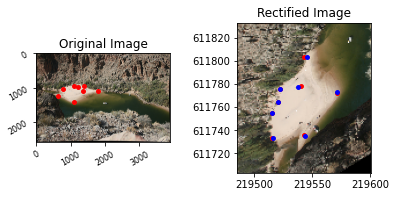

In [27]:
dst_l, H_low = rectify_low_res(RC0307Rf_2019,img_rgb)


Homography with .1x.1 meter pixels
 [[ 1.53761446e+00  7.57957195e+00 -7.65254175e+03]
 [ 4.03190095e+00  3.41520376e+00 -5.35098325e+03]
 [ 1.18275257e-03  2.32241978e-03  1.00000000e+00]]


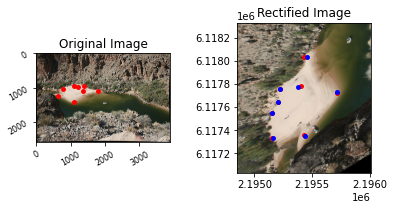

In [28]:
dst, H_high = rectify_hi_res(RC0307Rf_2019,img_rgb)

In [15]:
def estimate_homography_error(PanelDate, H,high_res = False):
    fct = 1
    x = PanelDate.impts[:,0]
    y = PanelDate.impts[:,1]
    points = np.vstack((fct*x, fct*y, np.ones(len(x))))
    #print(points)
    txyz = H.dot(points)
    #print(txyz)
    tx = txyz[0,:]
    ty = txyz[1,:]
    tz = txyz[2,:]
    tx = tx/tz
    ty = ty/tz
    if high_res == False:
      txc = tx + PanelDate.E_min
      tyc = ty + PanelDate.N_min
      nxE = np.array(txc)
      nyN = np.array(tyc)
      mapx = PanelDate.pts[:,0] + PanelDate.E_min
      mapy = PanelDate.pts[:,1] + PanelDate.N_min
      nNE = np.column_stack((nxE,nyN))
      #print(nNE)
      mappts_trans = np.column_stack((mapx,mapy))
      #print(mappts_trans)
      errors = nNE - mappts_trans
      ssq = np.sum(np.sqrt(errors**2),axis = 0)/len(errors)
    elif high_res == True:
      txc = tx + PanelDate.E_min*10
      tyc = ty + PanelDate.N_min*10
      nxE = np.array(txc)
      nyN = np.array(tyc)
      mapx = PanelDate.ptsHiRes[:,0] + PanelDate.E_min*10
      mapy = PanelDate.ptsHiRes[:,1] + PanelDate.N_min*10
      nNE = np.column_stack((nxE,nyN))
      #print(nNE)
      mappts_trans = np.column_stack((mapx,mapy))
      #print(mappts_trans)
      errors = nNE - mappts_trans
      errors = errors*.1
      ssq = np.sum(np.sqrt(errors**2),axis = 0)/len(errors)
    else:
      print("Error resolution not defined, choose high_res = 'True' or 'False'")
    #EmaxError = np.max(abs(error[:,0]))
    #NmaxError = np.max(abs(error[:,1]))
    print('Error all points in meters\n', errors)
    print('Sum of squared errors in all points:')
    print(f'SSE easting error {ssq[0]} meters\nSSE northing error {ssq[1]} meters')
    return errors, ssq

In [29]:
errors, ssq = estimate_homography_error(RC0307Rf_2019,H_high, high_res=True)

Error all points in meters
 [[ 2.77989271 -0.28936882]
 [-3.25601712 -0.42335305]
 [-0.29828189 -0.1218884 ]
 [-0.42986435  0.17662029]
 [ 0.03482313  0.45301708]
 [ 0.83318411  0.31632604]
 [ 0.99280727 -0.8684702 ]
 [-0.65676019  0.75695821]]
Sum of squared errors in all points:
SSE easting error 1.1602038450713734 meters
SSE northing error 0.42575026184786113 meters


In [17]:
# function to minimize error by randomly remove up to three GCPs and providing the points with the minimum error
def Minimize_homography_error(PanelDate,img_rgb,num_pts_rmvd = 1):
    if num_pts_rmvd > 4:
      print("can only remove up to 4 points, try again...")
    else:
      fct = 1
      N_points_removed = num_pts_rmvd
      N = 1000
      runs = []
      img_points = PanelDate.impts
      map_points = PanelDate.mappts 
      min_points = PanelDate.minpts 
      E_min = PanelDate.mappts[:,0].min()
      N_min = PanelDate.mappts[:,1].min()
      points_2 = map_points - min_points
      all_points = np.column_stack((img_points, points_2))
      # shuffle points
      for i in range(N):
          np.random.shuffle(all_points)
          removed_points = all_points[:N_points_removed]
          #print("Removed Points: ", removed_points)
          gcps_minus_removed = all_points[N_points_removed:]
          #print("Points Left: ",gcps_minus_removed)
          use_points = np.arange(len(gcps_minus_removed))
          # caluclate homography
          Homo, Stat = cv2.findHomography(gcps_minus_removed[use_points,:2],gcps_minus_removed[use_points,2:])
          # transform image points using homography to TMapx and TMapy
          x = gcps_minus_removed[:,0]
          y = gcps_minus_removed[:,1]
          points = np.vstack((fct*x, fct*y, np.ones(len(x))))
          txyz = Homo.dot(points)
          tx = txyz[0,:] 
          ty = txyz[1,:] 
          tz = txyz[2,:] 
          tx = tx/tz 
          ty = ty/tz
          txc = tx + E_min
          tyc = ty + N_min
          nxE = np.array(txc) # impts transformed using Homography E
          nxN = np.array(tyc) # impts transformed using Homography N
          Trans_image_points = np.column_stack((nxE,nxN)) # stack them together into single array
          MapE = gcps_minus_removed[:,2] + E_min # mappts - removed point
          MapN = gcps_minus_removed[:,3] + N_min # mappts - removed point
          Map_points = np.column_stack((MapE,MapN))
          error = Trans_image_points - Map_points
          sse = np.sum(np.sqrt(error**2), axis=0)/len(error)
          SSSE = np.sum(sse) 
          r_p = removed_points
          run_error_dict = {'Run':i,'Sum SSE':SSSE, "Removed":removed_points.copy(), "Remaining Points":gcps_minus_removed.copy(), "Homography":Homo.copy()}
          runs.append(run_error_dict)
          
      Lowest_Error = {'Run': 000, 'Sum SSE':1000, 'Removed Points':[[0,0]], 'Remaining Points': [[0,0]],"Homography": [[0,0]]}
      for item in runs:
        if item['Sum SSE'] < Lowest_Error['Sum SSE']:
          Lowest_Error['Sum SSE'] = item['Sum SSE']
          Lowest_Error['Run'] = item['Run']
          Lowest_Error['Removed Points'] = item['Removed']
          Lowest_Error['Remaining Points'] = item['Remaining Points']
          Lowest_Error["Homography"] = item["Homography"]
          
        else:
          continue
      print(f"Lowest error {Lowest_Error['Sum SSE']} found by removing points {Lowest_Error['Removed Points']}")
    return [Lowest_Error['Removed Points'],Lowest_Error['Remaining Points']]







In [30]:
pts = Minimize_homography_error(RC0307Rf_2019,img_rgb,4)
print(pts)


Lowest error 1.3694807421416044e-06 found by removing points [[1388.75   968.      37.509   72.796]
 [1085.    1426.      86.88    68.835]
 [1809.5   1095.75    57.644  100.324]
 [1354.5   1089.75    55.663   75.078]]
[array([[1388.75 ,  968.   ,   37.509,   72.796],
       [1085.   , 1426.   ,   86.88 ,   68.835],
       [1809.5  , 1095.75 ,   57.644,  100.324],
       [1354.5  , 1089.75 ,   55.663,   75.078]]), array([[1211.5  ,  983.75 ,   35.759,   61.155],
       [1093.75 ,  968.5  ,   30.123,   51.64 ],
       [ 782.   , 1029.   ,   30.438,   30.189],
       [ 641.5  , 1238.5  ,   57.715,   32.48 ]])]


In [31]:
# function to plot error surface 
def plot_error_surface(PanelDate,img_rgb, out_dir, high_res = True, save = False):
  ''' 
  inputs:
  > img_rgb
  > PanelDate
  > high_res = True
  > save_name
  > out_dir
  '''
  # check highres or low
  if high_res == True:
    # calculate homography
      dst, H_high = rectify_hi_res(PanelDate,img_rgb, plot = False)
      H = H_high
      E_max = PanelDate.E_maxHiRes
      N_max = PanelDate.N_maxHiRes
      minpts = PanelDate.minptsHiRes
      print("minpts", minpts)
      E_min = minpts[0]
      N_min = minpts[1]
      pts = PanelDate.ptsHiRes
      rows, cols, channels = dst.shape
      print("dst.shape",dst.shape)
      E_axis = np.linspace(E_min, E_min + cols, cols)
      N_axis = np.linspace(N_min, N_min + rows, rows)
      transE, transN = transform_points(PanelDate.impts,H, PanelDate.N_minHiRes, PanelDate.E_minHiRes)
    # calculate errors
      errors, ssq = estimate_homography_error(PanelDate, H,high_res = True)
      name_qual = 'HighRes'
      Extent = [E_axis.min(),E_axis.max(),N_axis.min(),N_axis.max()]
      Mapx = PanelDate.mappts[:,0]*10 # east
      Mapy = PanelDate.mappts[:,1]*10 # north
      print('Mapxy',Mapx, Mapy )
  else:
    # calculate homography
      dst, H_low = rectify_low_res(PanelDate,img_rgb, plot = False)
      H = H_low
      E_max = PanelDate.E_max
      N_max = PanelDate.N_max
      minpts = PanelDate.minpts
      print("minpts", minpts)
      E_min = minpts[0]
      N_min = minpts[1]
      pts = PanelDate.pts
      rows, cols, channels = dst.shape
      print("dst.shape",dst.shape)
      E_axis = np.linspace(E_min, E_min + cols, cols)
      N_axis = np.linspace(N_min, N_min + rows, rows)
      Extent = [E_axis.min(),E_axis.max(),N_axis.min(),N_axis.max()]
      transE, transN = transform_points(PanelDate.impts,H, PanelDate.N_min, PanelDate.E_min)
    # calculate errors
      errors, ssq = estimate_homography_error(PanelDate, H,high_res = False)
      name_qual = 'LowRes'
      Mapx = PanelDate.mappts[:,0] # east
      Mapy = PanelDate.mappts[:,1] # north
      print('Mapxy',Mapx, Mapy )


 
  Ptsx = pts[:,0]
  Ptsy = pts[:,1]
  TMapx= transE
  TMapy= transN
  EE = np.sqrt(errors[:,0]**2)
  EN = np.sqrt(errors[:,1]**2)
  EA = np.sqrt(EE * EN)
  Errors_all = np.column_stack((Mapx,Mapy,EA))
  xx, yy = np.meshgrid(np.arange(E_min, E_max,1),np.arange(N_min,N_max,1))
  intim_A = griddata((Errors_all[:,0],Errors_all[:,1]),Errors_all[:,2],(xx,yy))
  # make plot
  print('Extent',Extent)
  filename = 'Error_surface_' + PanelDate.sitename + '_' + PanelDate.year + '_' + name_qual + '.PNG'
  fig = plt.figure(figsize = (16,6))
  fig.subplots_adjust(wspace = 0.3)
  # plot original image
  ax = plt.subplot(1,3,1)
  plt.title("Original image")
  plt.imshow(img_rgb)
  plt.scatter(x = PanelDate.impts[:,0], y = PanelDate.impts[:,1], c = 'r', s = 5,
              label = 'GCPs')
  # plot rectified image
  ax = plt.subplot(1,3,2)
  plt.title('Rectified image')
  plt.imshow(dst, extent = Extent, origin = 'lower')
  rw = plt.scatter(x = Ptsx + E_axis.min(), y = Ptsy + N_axis.min() ,c = 'r', s = 5,
              label = 'R-W points')
  rp = plt.scatter(x = TMapx, y = TMapy,c = 'b', s = 5,
              label = 'Reprojected pts')
  plt.legend((rw,rp),('Real-world coords','Reprojected coords'),loc='lower right',
           ncol=1,
           fontsize=8)
  # plot error surface
  ax = plt.subplot(1,3,3)
  plt.title("Error surface")
  plt.pcolormesh(xx,yy,intim_A)
  plt.axis([E_min, E_max,N_min,N_max])
  cbar = plt.colorbar( shrink = .5)
  plt.scatter(x= Mapx,y=Mapy, c = 'r', s = 15, label = 'R-W points')
  plt.scatter(x=TMapx, y=TMapy, c = 'b', s = 15, label = "Reprojected points")
  figure_name = "Rectification_error_surface_" + PanelDate.sitename +'.png'
  if save == True:
    plt.savefig(out_dir + os.sep + figure_name, bbox_inches = 'tight', dpi = 600)
    plt.show()
    plt.close()
  else:
    plt.show()
    print('Figure not saved')

  



Homography with .1x.1 meter pixels
 [[ 1.53761446e+00  7.57957195e+00 -7.65254175e+03]
 [ 4.03190095e+00  3.41520376e+00 -5.35098325e+03]
 [ 1.18275257e-03  2.32241978e-03  1.00000000e+00]]
Plot = False
minpts [2194850, 6117030]
dst.shape (1300, 1160, 3)
Error all points in meters
 [[ 2.77989271 -0.28936882]
 [-3.25601712 -0.42335305]
 [-0.29828189 -0.1218884 ]
 [-0.42986435  0.17662029]
 [ 0.03482313  0.45301708]
 [ 0.83318411  0.31632604]
 [ 0.99280727 -0.8684702 ]
 [-0.65676019  0.75695821]]
Sum of squared errors in all points:
SSE easting error 1.1602038450713734 meters
SSE northing error 0.42575026184786113 meters
Mapxy [2195426.44 2195406.63 2195225.09 2195207.59 2195151.23 2195154.38
 2195427.15 2195718.8 ] [6118033.24 6117780.78 6117757.96 6117641.55 6117546.4  6117331.89
 6117354.8  6117718.35]
Extent [2194850.0, 2196010.0, 6117030.0, 6118330.0]


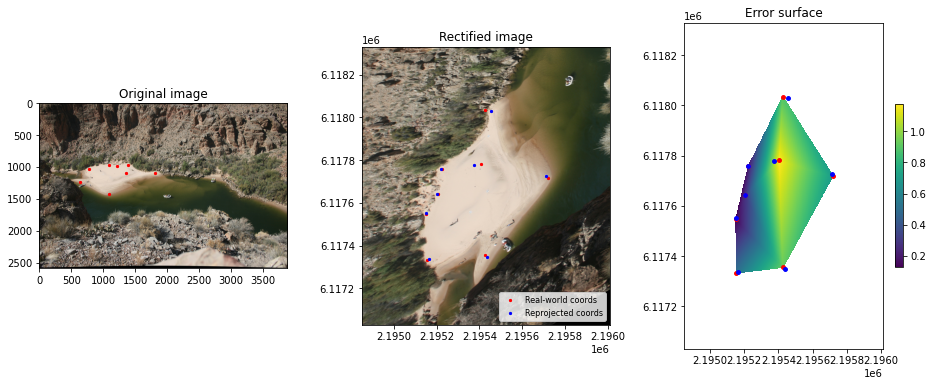

In [33]:
out = '/content/drive/My Drive/Colab_Notebooks/Rectification/RC0307Rf/Rec2020'
plot_error_surface(RC0307Rf_2019,img_rgb,out,high_res = True, save = True)